# Conservation Analysis of Genomic Features

This notebook analyzes conservation patterns in alternative transcript regions using PhyloCSF and PhyloP scores. The analysis pipeline is designed to handle multiple types of genomic features:
- N-terminal extensions (NTEs)
- C-terminal extensions (CTEs)
- Intronic regions

## Setup
First, we'll import required libraries and set up our basic configuration. We use:
- `polars` for efficient data manipulation
- `pyranges` for genomic interval operations
- `pyBigWig` for accessing conservation scores
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization

In [1]:
# Standard libraries
from pathlib import Path
import sys
from typing import List, Optional, Dict, Tuple
from datetime import datetime

# Add project root to Python path for imports
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom utilities
from src.utils import ConservationTracker, ConservationAnalyzer, BEDHandler

# Data handling
import polars as pl
import numpy as np
import pyranges as pr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()
sns.set_context("notebook")

## Configuration

Set up paths and parameters for the analysis. This notebook is configured for N-terminal extensions (NTEs), but the same structure can be used for CTEs and intronic regions by modifying these parameters.

Key parameters:
- Feature type (NTE/CTE/intronic)
- Input paths for feature data, annotations, and conservation scores
- Analysis parameters like window size
- Output directory structure

In [2]:
# Define feature type
FEATURE_TYPE = "NTE"  # One of: "NTE", "CTE", "INTRONIC"

# Set up directory structure
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results" / FEATURE_TYPE.lower()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Input paths
feature_path = DATA_DIR / "raw" / "NTEs.bed12"
leader_path = DATA_DIR / "raw" / "leaders.bed12"
gencode_path = DATA_DIR / "raw" / "gencode.v47.annotation.gtf"
phylocsf_dir = DATA_DIR / "raw" / "phylocsf"
phylop_path = DATA_DIR / "raw" / "phyloP" / "PhyloP_470way.bw"

# Analysis parameters
WINDOW_SIZE = 30  # Size of sliding window for conservation analysis
MIN_REGION_SIZE = 10  # Minimum size of region to analyze
SCORE_THRESHOLD = 0  # Threshold for calling positive conservation

# Initialize our utility classes
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)
bed_handler = BEDHandler()

# Verify paths exist
for path in [feature_path, gencode_path, phylocsf_dir, phylop_path]:
    if not path.exists():
        raise FileNotFoundError(f"Required file/directory not found: {path}")

print("Configuration complete. Analysis will use:")
print(f"- Feature type: {FEATURE_TYPE}")
print(f"- Feature data: {feature_path}")
print(f"- Results directory: {RESULTS_DIR}")

Configuration complete. Analysis will use:
- Feature type: NTE
- Feature data: ../data/raw/NTEs.bed12
- Results directory: ../results/nte


## Data Loading and Preprocessing

Load our N-terminal extension data from the BED12 file and prepare it for analysis. Steps include:
1. Load the BED12 file using our custom handler
2. Extract transcript IDs from feature names
3. Basic QC checks on the loaded data
4. Display summary statistics of our features

Loading feature data...

Feature Statistics:
Total features loaded: 20372

Chromosome distribution:
shape: (24, 2)
┌───────┬───────┐
│ chrom ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 1864  │
│ 10    ┆ 667   │
│ 11    ┆ 1373  │
│ 12    ┆ 1215  │
│ 13    ┆ 284   │
│ …     ┆ …     │
│ 7     ┆ 980   │
│ 8     ┆ 722   │
│ 9     ┆ 630   │
│ X     ┆ 825   │
│ Y     ┆ 1     │
└───────┴───────┘

Strand distribution:
shape: (2, 2)
┌────────┬───────┐
│ strand ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ +      ┆ 10673 │
│ -      ┆ 9699  │
└────────┴───────┘

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 20372.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 43146.989594  │
│ std        ┆ 79477.093943  │
│ min        ┆ 30.0          │
│ 25%        ┆ 6787.0        │
│ 50%        ┆ 1

/tmp/ipykernel_7754/2832992967.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
/tmp/ipykernel_7754/2832992967.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("strand").agg(pl.count()))


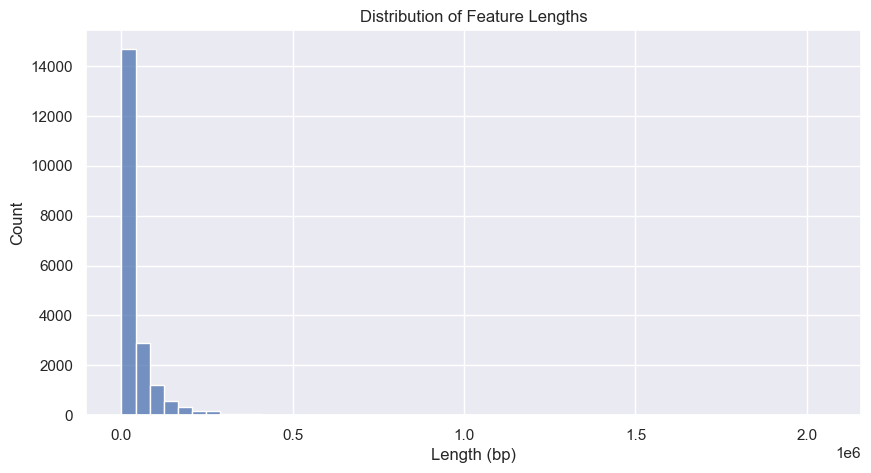


Data loading and preprocessing complete.


In [3]:
# Load feature data using our BED handler
print("Loading feature data...")
feature_df = bed_handler.load_bed12(feature_path)

# Extract transcript IDs from names and add region length
feature_df = feature_df.with_columns([
    # Extract transcript ID from feature name (assumes format: ENST00000123456_...)
    pl.col("name").str.split("_").list.first().alias("transcript_id"),
    
    # Calculate region length
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
])

# Print basic statistics
print("\nFeature Statistics:")
print(f"Total features loaded: {len(feature_df)}")
print("\nChromosome distribution:")
print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
print("\nStrand distribution:")
print(feature_df.group_by("strand").agg(pl.count()))
print("\nLength statistics:")
print(feature_df.select("region_length").describe())

# Quick length distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data=feature_df.to_pandas(), x="region_length", bins=50)
plt.title("Distribution of Feature Lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

print("\nData loading and preprocessing complete.")

## Extension Region Identification

Before calculating conservation scores, we need to precisely identify the extension regions by:
1. Loading CDS annotations from GENCODE
2. Identifying the correct CDS start/end positions
3. Determining the extension coordinates based on strand orientation:
   - For + strand: region between chromStart and CDS start
   - For - strand: region between CDS end and chromEnd
4. Validating extension regions

In [4]:
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)
cds_annotation = gr[gr.Feature == "CDS"]
exon_annotation = gr[gr.Feature == "exon"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")
print(f"Found {len(exon_annotation)} exon entries in GENCODE v47")

# Convert both to polars
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "chrom": [str(x).replace('chr', '') for x in cds_annotation.Chromosome.to_list()],
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})

Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47
Found 2155005 exon entries in GENCODE v47


In [5]:
# Read leader BED12
leader_df = bed_handler.load_bed12(leader_path)
print(f"Loaded {len(leader_df)} leader regions")

# Add transcript IDs
leader_df = leader_df.with_columns([
   pl.col("name").str.split("_").list.first().alias("transcript_id"),
])

# Join with CDS info
cds_regions = (cds_df
   .group_by("transcript_id")
   .agg([
       pl.col("strand").first(),
       pl.col("gene_name").first(),
       pl.col("cds_frame").first().alias("cds_frame"),
       pl.when(pl.col("strand").first() == "+")
       .then(pl.min("cds_start"))  
       .otherwise(pl.max("cds_end"))  
       .alias("cds_start_pos")
   ]))

leader_df = leader_df.join(
   cds_regions,
   on="transcript_id",
   how="left"
)

feature_df = feature_df.join(
   cds_regions,
   on="transcript_id",
   how="left"
)



Loaded 94260 leader regions


In [15]:
def parse_leader_blocks(leader_df, feature_df):
    """
    Split leader blocks into translated/untranslated based on matching with feature_df
    Also identifies CDS blocks (feature blocks without leader overlap)
    """
    results = []
    
    for leader_row in leader_df.iter_rows(named=True):
        transcript_id = leader_row['transcript_id']
        
        # Get matching feature row
        feature_matches = feature_df.filter(pl.col("transcript_id") == transcript_id)
        if len(feature_matches) == 0:
            continue
            
        feature_row = feature_matches.row(0, named=True)
        
        # Parse blocks
        leader_starts = [int(x) + leader_row['chromStart'] for x in leader_row['blockStarts'].split(',')]
        leader_sizes = [int(x) for x in leader_row['blockSizes'].split(',')]
        leader_ends = [s + sz for s, sz in zip(leader_starts, leader_sizes)]
        
        feature_starts = [int(x) + feature_row['chromStart'] for x in feature_row['blockStarts'].split(',')]
        feature_sizes = [int(x) for x in feature_row['blockSizes'].split(',')]
        feature_ends = [s + sz for s, sz in zip(feature_starts, feature_sizes)]
        
        translated_blocks = []
        untranslated_blocks = []
        cds_blocks = []
        
        # First process leader blocks
        for l_start, l_end in zip(leader_starts, leader_ends):
            translated = False
            
            # Check if leader block matches/overlaps any feature block
            for f_start, f_end in zip(feature_starts, feature_ends):
                if l_start == f_start and l_end == f_end:
                    # Exact match
                    translated_blocks.append((l_start, l_end))
                    translated = True
                    break
                elif l_start <= f_start and l_end > f_start:
                    # Split block
                    untranslated_blocks.append((l_start, f_start))
                    translated_blocks.append((f_start, l_end))
                    translated = True
                    break
                    
            if not translated:
                untranslated_blocks.append((l_start, l_end))
        
        # Now identify CDS blocks (feature blocks without leader overlap)
        for f_start, f_end in zip(feature_starts, feature_ends):
            has_overlap = False
            
            # Check against all leader blocks
            for l_start, l_end in zip(leader_starts, leader_ends):
                # Check for any overlap
                if not (f_end <= l_start or f_start >= l_end):
                    has_overlap = True
                    if f_start < l_start:
                        # Add non-overlapping portion at start
                        cds_blocks.append((f_start, l_start))
                    if f_end > l_end:
                        # Add non-overlapping portion at end
                        cds_blocks.append((l_end, f_end))
                    break
            
            if not has_overlap:
                # If no overlap at all, entire feature block is CDS
                cds_blocks.append((f_start, f_end))

        results.append({
            'transcript_id': transcript_id,
            'translated_blocks': translated_blocks,
            'untranslated_blocks': untranslated_blocks,
            'cds_blocks': cds_blocks
        })
        
    return pl.DataFrame(results)

# Apply the function
split_blocks_df = parse_leader_blocks(leader_df, feature_df)


# Split into two dataframes
result_df = feature_df.join(
   split_blocks_df,
   on="transcript_id",
   how="left"
)

# Print validation
print("\nJoined results:")
print(result_df.select([
   "transcript_id",
   "strand",
   "translated_blocks",
   "untranslated_blocks",
   "cds_blocks"
]).head())


Joined results:
shape: (5, 5)
┌─────────────────┬────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│ transcript_id   ┆ strand ┆ translated_blocks     ┆ untranslated_blocks   ┆ cds_blocks            │
│ ---             ┆ ---    ┆ ---                   ┆ ---                   ┆ ---                   │
│ str             ┆ str    ┆ list[list[i64]]       ┆ list[list[i64]]       ┆ list[list[i64]]       │
╞═════════════════╪════════╪═══════════════════════╪═══════════════════════╪═══════════════════════╡
│ ENST00000616016 ┆ +      ┆ [[924053, 924431]]    ┆ [[923922, 924053]]    ┆ [[924431, 924948],    │
│                 ┆        ┆                       ┆                       ┆ [925921, 92…          │
│ ENST00000618323 ┆ +      ┆ [[924053, 924431]]    ┆ [[923922, 924053]]    ┆ [[924431, 924948],    │
│                 ┆        ┆                       ┆                       ┆ [925921, 92…          │
│ ENST00000624697 ┆ +      ┆ [[1013992, 1014004]]  ┆ [[10011

## Conservation Score Calculation

Calculate both PhyloCSF and PhyloP conservation scores for extension regions using our utility classes. For each region we:
1. Use `ConservationTracker` to access scores
2. Calculate metrics using `ConservationAnalyzer`
3. Store results in a properly structured DataFrame

In [16]:
# Initialize conservation trackers
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)

def calculate_extension_frame(ext_length: int, cds_frame: int, strand: str) -> int:
    """
    Calculate the correct reading frame for the extension.
    
    Args:
        ext_length: Length of the extension
        cds_frame: Frame of the CDS (0, 1, or 2)
        strand: '+' or '-'
    
    Returns:
        Correct PhyloCSF frame (1, 2, or 3)
    """
    if strand == '+':
        # For + strand, we count backwards from CDS start
        offset = (3 - (ext_length % 3) + cds_frame) % 3
    else:
        # For - strand, we count forward from CDS end
        offset = (ext_length % 3 + cds_frame) % 3
    
    # Convert to PhyloCSF frame numbering (1-based)
    return offset + 1

def calculate_block_frame(block_start: int, block_end: int, initial_frame: int, strand: str) -> int:
    """
    Calculate the correct reading frame for a block based on its position and the initial frame.
    
    Args:
        block_start: Start position of the block
        block_end: End position of the block
        initial_frame: Initial frame (0-based)
        strand: '+' or '-'
    
    Returns:
        Frame for this block (0-based)
    """
    block_length = block_end - block_start
    
    if strand == '+':
        # For + strand, frame shifts forward with each block
        return ((initial_frame + block_length) % 3)
    else:
        # For - strand, frame shifts backward with each block
        return ((initial_frame - block_length) % 3 + 3) % 3

def calculate_region_scores(df, region_type, debug_transcript_ids=None):
    """
    Calculate scores for translated or untranslated regions with frame-aware block processing.
    Args:
        df: Input dataframe
        region_type: Type of region ('translated', 'untranslated', etc.)
        debug_transcript_ids: List of transcript IDs to print debug info for, or None for all
    """
    metrics_lists = {
        f'{region_type}_matched_frame_score': [],
        f'{region_type}_max_frame_score': [],
        f'{region_type}_start_region_score': [],
        f'{region_type}_window_max_score': [],
        f'{region_type}_phylop_mean': [],
        f'{region_type}_frame': [],
        f'{region_type}_length': []
    }
    
    for row in df.iter_rows(named=True):
        current_metrics = {key: None for key in metrics_lists.keys()}
        blocks = row[f'{region_type}_blocks']
        transcript_id = row['transcript_id']
        
        # Check if we should debug this transcript
        should_debug = False
        # (debug_transcript_ids is None or 
        #                transcript_id in debug_transcript_ids)
        
        if should_debug:
            print(f"\n{'='*80}")
            print(f"Processing {region_type} region for transcript: {transcript_id}")
            print(f"Strand: {row['strand']}")
            print(f"CDS frame: {row['cds_frame']}")
            print(f"Number of blocks: {len(blocks) if blocks else 0}")
        
        if not blocks or row['cds_frame'] is None:
            if should_debug:
                print("Skipping: No blocks or no CDS frame")
            for key in metrics_lists:
                metrics_lists[key].append(None)
            continue
            
        # Calculate total length and initial frame
        total_length = sum(end - start for start, end in blocks)
        current_metrics[f'{region_type}_length'] = total_length
        
        initial_frame = int(row['cds_frame'])  # 0-based frame
        current_metrics[f'{region_type}_frame'] = initial_frame
        
        if should_debug:
            print(f"Total length: {total_length}")
            print(f"Initial frame: {initial_frame}")
            print("\nBlock-by-block analysis:")
        
        # Process blocks sequentially, maintaining frame
        all_scores = []
        all_phylop = []
        current_frame = initial_frame
        
        for i, (start, end) in enumerate(blocks):
            is_first_block = i == 0
            block_length = end - start
            
            if should_debug:
                print(f"\nBlock {i+1}: {start}-{end} (length: {block_length}bp)")
                print(f"Starting frame: {current_frame}")
            1
            
            # Get conservation scores
            phylocsf_scores, phylop_scores = conservation_tracker.get_conservation_scores(
                row['chrom'],
                start,
                end,
                row['strand']
            )
            phylocsf_frame = (((start % 3) + 2) % 3) + 1

            if should_debug:
                print(f"Gencode frame: {(start)  % 3} (PhyloCSF frame: {phylocsf_frame})")
                print("Strand: ", row['strand'])

                if phylocsf_scores:
                    print({i: np.nanmean(phylocsf_scores[i]) for i in phylocsf_scores})
                    frame_scores = phylocsf_scores.get(phylocsf_frame, [])

            
            if phylocsf_scores:
                # Find frame with highest mean score
                max_frame = max(phylocsf_scores, key=lambda k: np.mean(phylocsf_scores[k]))
                frame_scores = phylocsf_scores.get(max_frame, [])
                all_scores.extend(frame_scores)
                        
            if phylop_scores is not None:
                all_phylop.extend(phylop_scores)
        
        if should_debug:
            print("\nFinal statistics:")
            print(f"Total scores collected: {len(all_scores)}")
            if all_scores:
                print(f"Score range: {min(all_scores):.2f} to {max(all_scores):.2f}")
                print(f"Mean score: {np.nanmean(all_scores):.2f}")
        
        # Calculate metrics using frame-aware scores
        if all_scores:
            mean_score = np.nanmean(all_scores)
            current_metrics[f'{region_type}_matched_frame_score'] = float(mean_score)
            current_metrics[f'{region_type}_max_frame_score'] = float(mean_score)
            
            if len(all_scores) >= 15:
                current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(all_scores[:15]))
            
            if len(all_scores) >= 30:
                windows = [np.nanmean(all_scores[i:i+30]) for i in range(len(all_scores) - 29)]
                current_metrics[f'{region_type}_window_max_score'] = float(max(windows))
        
        if all_phylop:
            current_metrics[f'{region_type}_phylop_mean'] = float(np.nanmean(all_phylop))
            

        for key in metrics_lists:
            metrics_lists[key].append(current_metrics[key])
            
    return df.with_columns([
        pl.Series(name, values) for name, values in metrics_lists.items()
    ])


print("Calculating conservation scores...")
# Calculate scores for both regions
# debug_ids = ["ENST00000379031"]
# scored_df_test = calculate_region_scores(result_df, 'cds', debug_transcript_ids=debug_ids)


# scored_df_test.head()

Calculating conservation scores...


In [17]:
print("Calculating conservation scores...")
# Calculate scores for both regions
translated_scored_df = calculate_region_scores(result_df, 'translated')


Calculating conservation scores...


/tmp/ipykernel_7754/235626429.py:153: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(all_scores)
/tmp/ipykernel_7754/235626429.py:158: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(all_scores[:15]))
/tmp/ipykernel_7754/235626429.py:161: RuntimeWarning: Mean of empty slice
  windows = [np.nanmean(all_scores[i:i+30]) for i in range(len(all_scores) - 29)]
/tmp/ipykernel_7754/235626429.py:165: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_phylop_mean'] = float(np.nanmean(all_phylop))


In [18]:
untranslated_translated_scored_df = calculate_region_scores(translated_scored_df, 'untranslated')


Error accessing bigwig for chr1:1022200-1022200: Invalid interval bounds!
Error accessing bigwig for chr1:1022200-1022200: Invalid interval bounds!
Error accessing bigwig for chr1:1022200-1022200: Invalid interval bounds!
Error accessing bigwig for chr1:1022200-1022200: Invalid interval bounds!
Error accessing bigwig for chr1:1623388-1623388: Invalid interval bounds!
Error accessing bigwig for chr1:1623388-1623388: Invalid interval bounds!
Error accessing bigwig for chr1:1623388-1623388: Invalid interval bounds!
Error accessing bigwig for chr1:1623388-1623388: Invalid interval bounds!
Error accessing bigwig for chr1:1623430-1623430: Invalid interval bounds!
Error accessing bigwig for chr1:1623430-1623430: Invalid interval bounds!
Error accessing bigwig for chr1:1623430-1623430: Invalid interval bounds!
Error accessing bigwig for chr1:1623430-1623430: Invalid interval bounds!
Error accessing bigwig for chr1:1623430-1623430: Invalid interval bounds!
Error accessing bigwig for chr1:162343

/tmp/ipykernel_7754/235626429.py:158: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(all_scores[:15]))
/tmp/ipykernel_7754/235626429.py:165: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_phylop_mean'] = float(np.nanmean(all_phylop))


Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error accessing bigwig for chr1:11989164-11989164: Invalid interval bounds!
Error access

/tmp/ipykernel_7754/235626429.py:153: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(all_scores)
/tmp/ipykernel_7754/235626429.py:161: RuntimeWarning: Mean of empty slice
  windows = [np.nanmean(all_scores[i:i+30]) for i in range(len(all_scores) - 29)]


Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22643995-22643995: Invalid interval bounds!
Error accessing bigwig for chr1:22644010-22644010: Invalid interval bounds!
Error accessing bigwig for chr1:22644010-22644010: Invalid interval bounds!
Error accessing bigwig for chr1:22644010-22644010: Invalid interval bounds!
Error accessing bigwig for chr1:22644010-22644010: Invalid interval bounds!
Error accessing bigwig for chr1:22644010-22644010: Invalid interval bounds!
Error access

In [19]:
scored_df = calculate_region_scores(untranslated_translated_scored_df, 'cds')


# Add genome coordinates for reference
scored_df = scored_df.with_columns(
   (pl.col("chrom") + ":" + 
    pl.col("chromStart").cast(pl.Utf8) + "-" +
    pl.col("cds_start_pos").cast(pl.Utf8)
   ).alias("genome_coords")
)


scored_df.head()

/tmp/ipykernel_7754/235626429.py:161: RuntimeWarning: Mean of empty slice
  windows = [np.nanmean(all_scores[i:i+30]) for i in range(len(all_scores) - 29)]
/tmp/ipykernel_7754/235626429.py:158: RuntimeWarning: Mean of empty slice
  current_metrics[f'{region_type}_start_region_score'] = float(np.nanmean(all_scores[:15]))
/tmp/ipykernel_7754/235626429.py:153: RuntimeWarning: Mean of empty slice
  mean_score = np.nanmean(all_scores)


chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,transcript_id,region_length,strand_right,gene_name,cds_frame,cds_start_pos,translated_blocks,untranslated_blocks,cds_blocks,translated_matched_frame_score,translated_max_frame_score,translated_start_region_score,translated_window_max_score,translated_phylop_mean,translated_frame,translated_length,untranslated_matched_frame_score,untranslated_max_frame_score,untranslated_start_region_score,untranslated_window_max_score,untranslated_phylop_mean,untranslated_frame,untranslated_length,cds_matched_frame_score,cds_max_frame_score,cds_start_region_score,cds_window_max_score,cds_phylop_mean,cds_length,genome_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,str,i64,str,str,i64,i64,list[list[i64]],list[list[i64]],list[list[i64]],f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,str
"""1""",924053,944153,"""ENST00000616016""",2913,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,138,163,1…","""0,1868,6101,6985,11718,14986,1…","""ENST00000616016""",20100,"""+""","""SAMD11""",0,924431,"[[924053, 924431]]","[[923922, 924053]]","[[924431, 924948], [925921, 926013], … [943907, 944153]]",-10.18945,-10.18945,-14.4392,2.2537,0.827685,0,378,-7.321,-7.321,-5.356667,-2.7257,1.380321,0,131,13.442441,13.442441,13.426,38.9958,3.531351,2535,"""1:924053-924431"""
"""1""",924053,944153,"""ENST00000618323""",2916,"""+""",924053,944153,0,14,"""895,92,182,51,125,90,141,163,1…","""0,1868,6101,6985,11718,14986,1…","""ENST00000618323""",20100,"""+""","""SAMD11""",0,924431,"[[924053, 924431]]","[[923922, 924053]]","[[924431, 924948], [925921, 926013], … [943907, 944153]]",-10.18945,-10.18945,-14.4392,2.2537,0.827685,0,378,-7.321,-7.321,-5.356667,-2.7257,1.380321,0,131,13.382125,13.382125,13.426,38.9958,3.536539,2538,"""1:924053-924431"""
"""1""",1013992,1014478,"""ENST00000624697""",486,"""+""",1013992,1014478,0,1,"""486""","""0""","""ENST00000624697""",486,"""+""","""ISG15""",0,1014004,"[[1013992, 1014004]]","[[1001137, 1001281], [1008193, 1008279], [1013983, 1013992]]","[[1014004, 1014478]]",-1.20575,-1.20575,null,null,5.15275,0,12,-11.00331,-11.00331,-13.139,-2.2135,-1.149397,0,239,-0.390734,-0.390734,1.2078,28.5346,0.850629,474,"""1:1013992-1014004"""
"""1""",1013501,1014478,"""ENST00000649529""",570,"""+""",1013501,1014478,0,2,"""75,495""","""0,482""","""ENST00000649529""",977,"""+""","""ISG15""",0,1013573,"[[1013501, 1013573]]","[[1013496, 1013501]]","[[1013573, 1013576], [1013983, 1014478]]",-26.279936,-26.279936,-13.432733,-18.095476,-0.91575,0,72,-6.954,-6.954,null,null,-0.467,0,5,-0.993633,-0.993633,-19.1166,28.5346,0.95302,498,"""1:1013501-1013573"""
"""1""",1020172,1054981,"""ENST00000620552""",6207,"""+""",1020172,1054981,0,39,"""201,262,48,216,225,225,207,219…","""0,2028,15104,20492,21000,21305…","""ENST00000620552""",34809,"""+""","""AGRN""",0,1022413,"[[1020172, 1020373], [1022200, 1022413]]","[[1020122, 1020172], [1022200, 1022200]]","[[1022413, 1022462], [1035276, 1035324], … [1054823, 1054981]]",6.201217,6.201217,-0.684467,28.6434,5.397932,0,414,-5.43138,-5.43138,0.7294,-3.681,1.8229,0,50,16.413578,16.413578,37.2076,46.857199,3.258753,5793,"""1:1020172-1022413"""


## High-Confidence Extension Analysis

Filter and categorize the extensions based on conservation scores:
1. Filter for positive PhyloCSF scores (indicating coding potential)
2. Sort by conservation strength
3. Separate novel vs. overlapping extensions
4. Generate visualizations and summary statistics

In [20]:
def write_scored_bed(df, score_col, output_path, normalize=False, scale_factor=1000):
    """
    Write BED file with specified score column in proper BED format.
    
    Args:
        df: polars DataFrame with genomic data
        score_col: name of column containing scores
        output_path: path to write BED file
        normalize: if True, normalize scores to 0-1000 range for genome browser (default: False)
        scale_factor: scaling factor for normalization (default: 1000)
    """
    
    # Start with score handling
    score_expr = (
        pl.when(pl.col(score_col).is_null() | pl.col(score_col).is_nan())
        .then(0)
        .otherwise(
            pl.when(normalize)
            .then(
                # Normalize to 0-1000 for genome browser
                ((pl.col(score_col) - pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) / 
                 (pl.col(score_col).filter(~pl.col(score_col).is_nan()).max() - 
                  pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) * scale_factor)
                .floor()
                .cast(pl.Int64)
                .clip(0, 1000)
            )
            .otherwise(
                # Keep original scores, just handle null/nan
                pl.col(score_col)
            )
        )
    )
    
    # Create BED format DataFrame
    bed_df = (df
        .filter(~pl.col(score_col).is_null() & ~pl.col(score_col).is_nan())
        .with_columns([
            # Add 'chr' prefix to chrom
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            
            # Handle start/end coordinates ensuring start <= end
            pl.when(pl.col("chromStart") > pl.col("chromEnd"))
            .then(pl.col("chromEnd"))
            .otherwise(pl.col("chromStart"))
            .alias("start"),
            
            pl.when(pl.col("chromStart") > pl.col("chromEnd"))
            .then(pl.col("chromStart"))
            .otherwise(pl.col("chromEnd"))
            .alias("end"),
            
            # Add processed scores
            score_expr.alias("bed_score")
        ])
        # Select and reorder columns for BED format
        .select([
            "chr_name",
            "start",
            "end",
            "transcript_id",
            "bed_score",
            "strand"
        ])
        # Filter out invalid entries
        .filter(
            (pl.col("start").is_not_null()) &
            (pl.col("end").is_not_null())
        ))
    
    # Write the BED file
    bed_df.write_csv(
        output_path, 
        separator="\t", 
        include_header=False
    )
    
    # Print summary statistics
    print(f"Wrote {len(bed_df)} entries to {output_path}")
    print("\nScore statistics:")
    print(bed_df.select("bed_score").describe())
    print("\nFirst few lines of BED file:")
    print(bed_df.head())
    
    return bed_df


In [21]:
scored_df_checkpoint = scored_df.clone()

In [22]:
scored_df = scored_df_checkpoint.clone()


Score statistics:
shape: (10, 8)
┌────────────┬───────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ transcript ┆ gene_name ┆ translated ┆ translated ┆ untransla ┆ untransla ┆ cds_match ┆ cds_phylo │
│ _id        ┆ ---       ┆ _matched_f ┆ _phylop_me ┆ ted_match ┆ ted_phylo ┆ ed_frame_ ┆ p_mean    │
│ ---        ┆ str       ┆ rame_score ┆ an         ┆ ed_frame_ ┆ p_mean    ┆ score     ┆ ---       │
│ str        ┆           ┆ ---        ┆ ---        ┆ sco…      ┆ ---       ┆ ---       ┆ f64       │
│            ┆           ┆ f64        ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆           │
│            ┆           ┆            ┆            ┆ f64       ┆           ┆           ┆           │
╞════════════╪═══════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ENST000006 ┆ SAMD11    ┆ -10.18945  ┆ 0.827685   ┆ -7.321    ┆ 1.380321  ┆ 13.442441 ┆ 3.531351  │
│ 16016      ┆           ┆            ┆            ┆     

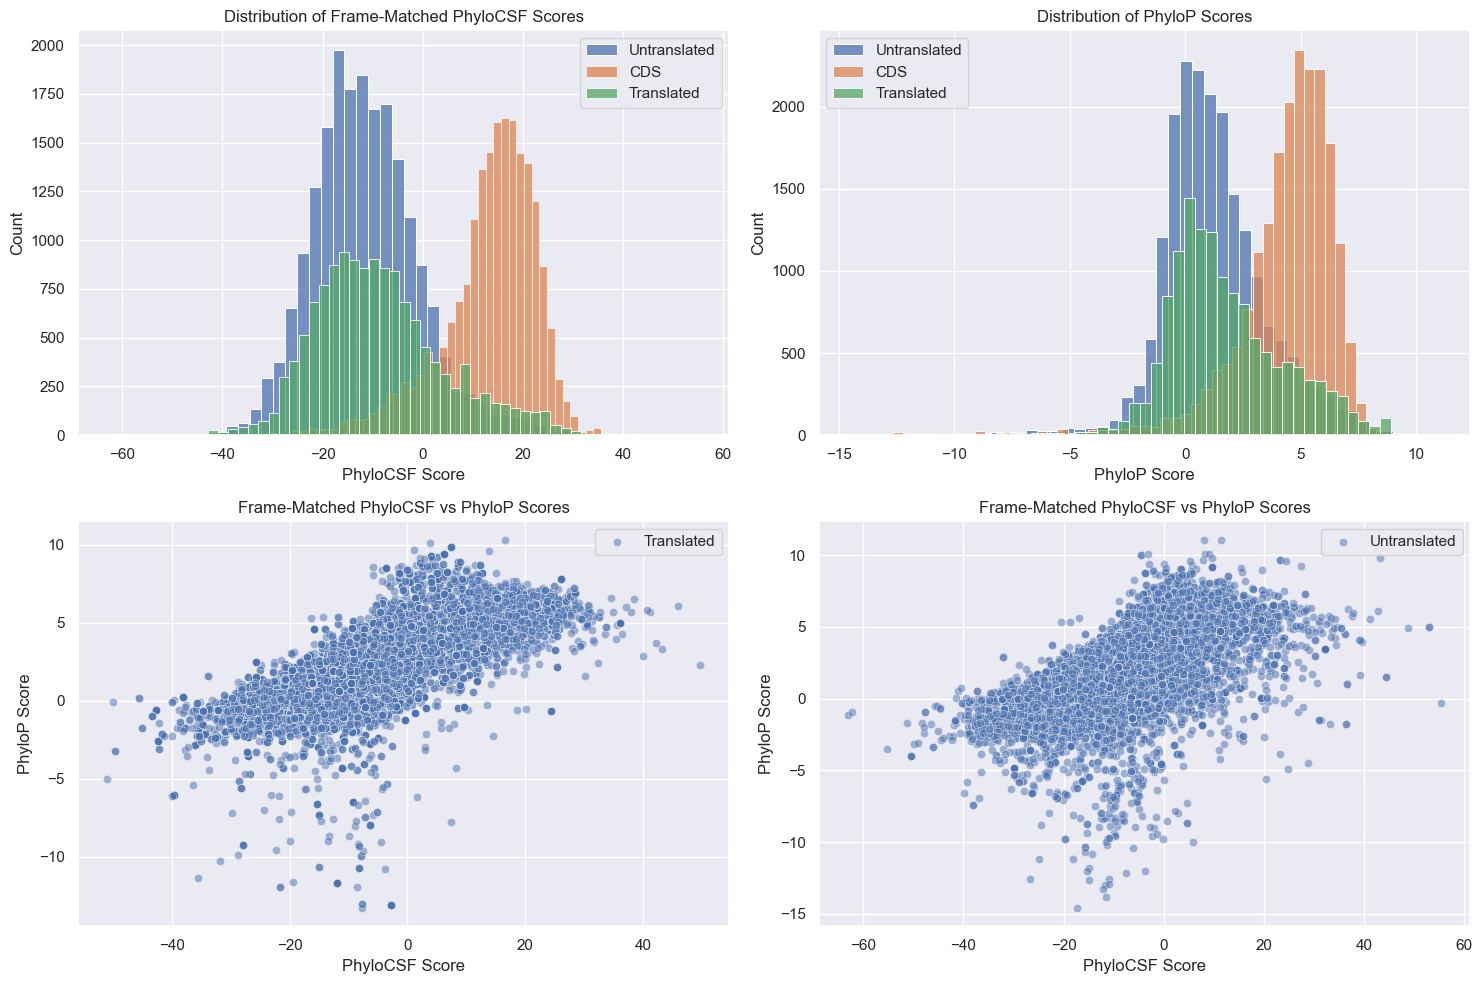


Writing translated matched_frame BED file...
Wrote 13619 entries to ../results/nte/bed/leader_translated_matched_frame.bed

Score statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ bed_score  │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 13619.0    │
│ null_count ┆ 0.0        │
│ mean       ┆ -8.633057  │
│ std        ┆ 13.112195  │
│ min        ┆ -50.896858 │
│ 25%        ┆ -17.821876 │
│ 50%        ┆ -10.122708 │
│ 75%        ┆ -1.496329  │
│ max        ┆ 49.613667  │
└────────────┴────────────┘

First few lines of BED file:
shape: (5, 6)
┌──────────┬─────────┬─────────┬─────────────────┬────────────┬────────┐
│ chr_name ┆ start   ┆ end     ┆ transcript_id   ┆ bed_score  ┆ strand │
│ ---      ┆ ---     ┆ ---     ┆ ---             ┆ ---        ┆ ---    │
│ str      ┆ i64     ┆ i64     ┆ str             ┆ f64        ┆ str    │
╞══════════╪═════════╪═════════╪═════════════════╪════════════╪════════╡
│ chr1     ┆ 9

In [23]:
# Show distribution of scores for both regions
print("\nScore statistics:")
print(scored_df.select([
  "transcript_id",
  "gene_name",
  "translated_matched_frame_score",
  "translated_phylop_mean",
  "untranslated_matched_frame_score", 
  "untranslated_phylop_mean",
  "cds_matched_frame_score",
  "cds_phylop_mean"

]).head(10))

# Create visualization comparing translated vs untranslated regions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Matched frame scores distribution
sns.histplot(
   data=scored_df.to_pandas(),
   x="untranslated_max_frame_score", 
   label="Untranslated",
   bins=50,
   ax=axes[0]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="cds_max_frame_score", 
   label="CDS",
   bins=50,
   ax=axes[0]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="translated_max_frame_score",
   label="Translated",
   bins=50,
   ax=axes[0]
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP distributions

sns.histplot(
   data=scored_df.to_pandas(),
   x="untranslated_phylop_mean",
   label="Untranslated",
   bins=50,
   ax=axes[1]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="cds_phylop_mean",
   label="CDS",
   bins=50,
   ax=axes[1]
)
sns.histplot(
   data=scored_df.to_pandas(),
   x="translated_phylop_mean",
   label="Translated",
   bins=50,
   ax=axes[1]
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF vs PhyloP - Translated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   y="translated_phylop_mean",
   alpha=0.5,
   ax=axes[2],
   label="Translated"
)
axes[2].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")
axes[2].legend()

# PhyloCSF vs PhyloP - Untranslated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score",
   y="untranslated_phylop_mean",
   alpha=0.5,
   ax=axes[3],
   label="Untranslated"
)
axes[3].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[3].set_xlabel("PhyloCSF Score")
axes[3].set_ylabel("PhyloP Score")
axes[3].legend()

plt.tight_layout()
plt.show()

# Write BED files for both regions
for region in ['translated', 'untranslated']:
   for score_type, column in {
       "matched_frame": f"{region}_matched_frame_score",
       "phylop": f"{region}_phylop_mean",
       "window_max": f"{region}_window_max_score"
   }.items():
       output_path = RESULTS_DIR / "bed" / f"leader_{region}_{score_type}.bed"
       print(f"\nWriting {region} {score_type} BED file...")
       write_scored_bed(scored_df, column, output_path)

# Print diagnostics
print("\nScore column statistics:")
for region in ['translated', 'untranslated']:
   for metric in ["matched_frame_score", "phylop_mean", "window_max_score"]:
       col = f"{region}_{metric}"
       print(f"\n{col}:")
       print(f"Total values: {len(scored_df)}")
       print(f"Null values: {scored_df.filter(pl.col(col).is_null()).height}")
       print(f"NaN values: {scored_df.filter(pl.col(col).is_nan()).height}")
       print(f"Negative values: {scored_df.filter(pl.col(col) < 0).height}")
       print("Overall statistics:")
       print(scored_df.select(pl.col(col)).describe())

## Finding Novel Extension Regions

After calculating conservation scores for all potential N-terminal extensions, we need to identify which ones are truly novel (i.e., don't overlap with known coding sequences in other transcripts). This requires:

1. Prerequisites:
  - Bedtools installed (`conda install -c bioconda bedtools`)
  - Our scored BED files from the conservation analysis
  - GENCODE v47 CDS annotations in BED format

2. Steps to identify novel extensions:

```bash
# First convert GENCODE GTF CDS regions to BED
# If using UCSC genome browser coordinates (our case):
awk '$3=="CDS" {print $1"\t"$4-1"\t"$5}' data/raw/gencode.v47.annotation.gtf > gencode.v47.cds.bed

# Use bedtools intersect to find non-overlapping regions
# For matched frame scores:
bedtools intersect -v -a nte_matched_frame_20241031.bed -b gencode.v47.cds.bed > novel_nte_matched_frame.bed

# For PhyloP scores:
bedtools intersect -v -a nte_phylop_20241031.bed -b gencode.v47.cds.bed > novel_nte_phylop.bed

# For window max scores:
bedtools intersect -v -a nte_window_max_20241031.bed -b gencode.v47.cds.bed > novel_nte_window_max.bed

In [ ]:
import pandas as pd

def generate_novel_beds(scored_df, gencode_pyranges, output_dir, date_str):
    """
    Generate both full and novel (non-CDS-overlapping) BED files
    """
    # First get CDS regions from GENCODE
    print("Loading GENCODE CDS regions...")
    cds_gr = gencode_pyranges[gencode_pyranges.Feature == "CDS"]
    
    # Convert CDS to BED format (chr, start, end)
    cds_bed = pd.DataFrame({
        'Chromosome': cds_gr.Chromosome,
        'Start': cds_gr.Start,
        'End': cds_gr.End
    })
    cds_gr = pr.PyRanges(cds_bed)
    
    # Generate BED files for different score types
    score_pairs = {
        "phylocsf": ("translated_matched_frame_score", "untranslated_matched_frame_score"),
        "phylop": ("translated_phylop_mean", "untranslated_phylop_mean")
    }
    
    results = {}
    for score_type, (translated_col, untranslated_col) in score_pairs.items():
        # Generate full BED file
        full_path = output_dir / f"nte_{score_type}_{date_str}.bed"
        print(f"\nGenerating {score_type} BED files...")

        full_bed_df = scored_df.explode("translated_blocks").with_columns([
            pl.col("translated_blocks").list.get(0).alias("genomic_start"),
            pl.col("translated_blocks").list.get(1).alias("genomic_end")
        ]).select(
            [
                "chrom",
                "genomic_start",
                "genomic_end",
                "name",
                "translated_matched_frame_score",
                "strand",
                "translated_blocks"
            ]
        )
        full_bed_df_no_na = full_bed_df.drop_nulls(
            ["genomic_start", "genomic_end", "translated_blocks"]
            )
        full_gr_df = pd.DataFrame({
                'Chromosome': full_bed_df_no_na['chrom'],
                'Start': full_bed_df_no_na['genomic_start'],
                'End': full_bed_df_no_na['genomic_end'],
                'Name': full_bed_df_no_na['name'],
                'Score': full_bed_df_no_na['translated_matched_frame_score'],
                'Strand': full_bed_df_no_na['strand']
            })
        
        

        print(full_bed_df)
        # Convert to PyRanges
        full_gr = pr.PyRanges(
            full_gr_df
        )
        
        # Find non-overlapping regions
        novel_gr = full_gr.subtract(cds_gr)
        print(full_gr.count_overlaps(cds_gr))

        # Save novel regions
        novel_path = output_dir / f"novel_nte_{score_type}_{date_str}.bed"
        novel_gr.to_bed(novel_path)
        
        print(f"Wrote {len(full_gr)} regions to {full_path}")
        print(f"Wrote {len(novel_gr)} novel regions to {novel_path}")
        
        results[score_type] = {
            'full': full_gr,
            'novel': novel_gr
        }
    
    return results

date_str = datetime.now().strftime("%Y%m%d")


# Use in your notebook after scoring:
novel_results = generate_novel_beds(
    scored_df=scored_df,
    gencode_pyranges=gr,
    output_dir=RESULTS_DIR / "novel_bed",
    date_str=date_str
)

# Print summary statistics
for score_type in novel_results:
    full_count = len(novel_results[score_type]['full'])
    novel_count = len(novel_results[score_type]['novel'])
    print(f"\n{score_type} results:")
    print(f"Total regions: {full_count}")
    print(f"Novel regions: {novel_count}")
    print(f"Percentage novel: {(novel_count/full_count)*100:.1f}%")

Loading GENCODE CDS regions...

Generating phylocsf BED files...
shape: (25_462, 7)
┌───────┬───────────────┬─────────────┬─────────────────┬────────────────┬────────┬────────────────┐
│ chrom ┆ genomic_start ┆ genomic_end ┆ name            ┆ translated_mat ┆ strand ┆ translated_blo │
│ ---   ┆ ---           ┆ ---         ┆ ---             ┆ ched_frame_sco ┆ ---    ┆ cks            │
│ str   ┆ i64           ┆ i64         ┆ str             ┆ re             ┆ str    ┆ ---            │
│       ┆               ┆             ┆                 ┆ ---            ┆        ┆ list[i64]      │
│       ┆               ┆             ┆                 ┆ f64            ┆        ┆                │
╞═══════╪═══════════════╪═════════════╪═════════════════╪════════════════╪════════╪════════════════╡
│ 1     ┆ 924053        ┆ 924431      ┆ ENST00000616016 ┆ -10.18945      ┆ +      ┆ [924053,       │
│       ┆               ┆             ┆                 ┆                ┆        ┆ 924431]        │
│ 1    

/home/jack/anaconda3/translon-conservation/lib/python3.12/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])
/home/jack/anaconda3/translon-conservation/lib/python3.12/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])


+--------------+-----------+-----------+-----------------+-------+
| Chromosome   | Start     | End       | Name            | +3    |
| (category)   | (int64)   | (int64)   | (object)        | ...   |
|--------------+-----------+-----------+-----------------+-------|
| 1            | 924053    | 924431    | ENST00000616016 | ...   |
| 1            | 924053    | 924431    | ENST00000618323 | ...   |
| 1            | 1013992   | 1014004   | ENST00000624697 | ...   |
| 1            | 1013501   | 1013573   | ENST00000649529 | ...   |
| ...          | ...       | ...       | ...             | ...   |
| X            | 154515909 | 154516230 | ENST00000449971 | ...   |
| X            | 154515909 | 154516215 | ENST00000416319 | ...   |
| X            | 154547467 | 154547572 | ENST00000393564 | ...   |
| X            | 154547467 | 154547572 | ENST00000369620 | ...   |
+--------------+-----------+-----------+-----------------+-------+
Stranded PyRanges object has 18,832 rows and 7 columns from 24

/home/jack/anaconda3/translon-conservation/lib/python3.12/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])
/home/jack/anaconda3/translon-conservation/lib/python3.12/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])


## Results Output Organization

We should save both figures and data files for reproducibility and future reference. Here's what we should output:

### Figures
1. **Distribution Plots** (`results/nte/figures/`)
  - Score distributions:
    ```python
    # Distribution plots (4-panel)
    fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.pdf")
    fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.png", dpi=300)
    ```

2. **Correlation Plots**
  - PhyloCSF vs PhyloP
  - Score vs length relationships
  - Separate plots for clarity

### Tables/Data Files 
1. **Summary Statistics** (`results/nte/tables/`)


In [ ]:
# Create directory structure
RESULTS_DIR = Path("../results/nte_leader")  # Changed directory name
for subdir in ["figures", "tables", "bed"]:
   (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)

date_str = datetime.now().strftime("%Y%m%d")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Frame scores comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_matched_frame_score",
       bins=50,
       ax=axes[0],
       label=region.capitalize()
   )
axes[0].set_title("Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_phylop_mean",
       bins=50,
       ax=axes[1],
       label=region.capitalize()
   )
axes[1].set_title("PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF vs PhyloP for translated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   y="translated_phylop_mean",
   alpha=0.5,
   ax=axes[2]
)
axes[2].set_title("Translated Regions: PhyloCSF vs PhyloP")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")

# PhyloCSF vs PhyloP for untranslated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score",
   y="untranslated_phylop_mean",
   alpha=0.5,
   ax=axes[3]
)
axes[3].set_title("Untranslated Regions: PhyloCSF vs PhyloP")
axes[3].set_xlabel("PhyloCSF Score")
axes[3].set_ylabel("PhyloP Score")

plt.tight_layout()

# Save figures
fig.savefig(RESULTS_DIR / "figures" / f"leader_score_distributions_{date_str}.pdf")
fig.savefig(RESULTS_DIR / "figures" / f"leader_score_distributions_{date_str}.png", dpi=300)

# Save summary statistics for both regions
for region in ['translated', 'untranslated']:
   metrics = [
       f"{region}_matched_frame_score",
       f"{region}_max_frame_score",
       f"{region}_start_region_score",
       f"{region}_window_max_score",
       f"{region}_phylop_mean",
       f"{region}_length"
   ]
   summary_stats = scored_df.select(metrics).describe()
   summary_stats.write_csv(RESULTS_DIR / "tables" / f"leader_{region}_summary_{date_str}.tsv", separator="\t")

# Save BED files for both regions
# Function to unpack blocks into separate rows
def unpack_blocks(df: pl.DataFrame, block_col: str) -> pl.DataFrame:
    unpacked_rows = []
    for row in df.iter_rows(named=True):
        blocks = row[block_col]
        if not blocks:
            continue
        for start, end in blocks:
            row_dict = {k: v for k, v in row.items() if k != block_col}
            row_dict['block_start'] = start
            row_dict['block_end'] = end
            unpacked_rows.append(row_dict)
    return pl.DataFrame(unpacked_rows)

def unpack_blocks_to_strings(df: pl.DataFrame) -> pl.DataFrame:
   unpacked = []
   for row in df.iter_rows(named=True):
       new_row = {k:v for k,v in row.items() if k not in ['translated_blocks', 'untranslated_blocks', 'cds_blocks']}
       
       translated = row['translated_blocks'] or []
       untranslated = row['untranslated_blocks'] or []
       cds = row['cds_blocks']
       
       new_row['translated_block_starts'] = str([start for start, _ in translated])
       new_row['translated_block_ends'] = str([end for _, end in translated])
       new_row['untranslated_block_starts'] = str([start for start, _ in untranslated])
       new_row['untranslated_block_ends'] = str([end for _, end in untranslated])
       new_row['cds_block_starts'] = str([start for start, _ in cds])
       new_row['cds_block_ends'] = str([end for _, end in cds])

       unpacked.append(new_row)
   
   return pl.DataFrame(unpacked)

scored_df = unpack_blocks_to_strings(scored_df)

scored_df.write_csv(RESULTS_DIR / "tables" / f"leader_full_results_{date_str}.tsv", separator="\t")

# Save high-confidence results for both regions
high_conf = scored_df.filter(
   (pl.col("translated_matched_frame_score") > 10) &
   (pl.col("translated_phylop_mean") > 2)
)
high_conf.write_csv(RESULTS_DIR / "tables" / f"leader_high_confidence_{date_str}.tsv", separator="\t")


# For BED files, use the unpacked dataframes
for region in ['translated', 'untranslated']:
   for score_type, column in {
       "matched_frame": f"{region}_matched_frame_score",
       "phylop": f"{region}_phylop_mean",
       "window_max": f"{region}_window_max_score"
   }.items():
       output_path = RESULTS_DIR / "bed" / f"leader_{region}_{score_type}_{date_str}.bed"
       write_scored_bed(scored_df, column, output_path)

print(f"Results saved in {RESULTS_DIR}")

In [ ]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Frame scores comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_matched_frame_score",
       bins=50,
       ax=axes[0],
       label=region.capitalize()
   )
axes[0].set_title("Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP comparison
for region in ['translated', 'untranslated']:
   sns.histplot(
       data=scored_df.to_pandas(),
       x=f"{region}_phylop_mean",
       bins=50,
       ax=axes[1],
       label=region.capitalize()
   )
axes[1].set_title("PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF vs PhyloP for translated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="translated_matched_frame_score",
   y="translated_phylop_mean",
   alpha=0.5,
   ax=axes[2]
)
axes[2].set_title("Translated Regions: PhyloCSF vs PhyloP")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")

# PhyloCSF vs PhyloP for untranslated
sns.scatterplot(
   data=scored_df.to_pandas(),
   x="untranslated_matched_frame_score",
   y="untranslated_phylop_mean",
   alpha=0.5,
   ax=axes[3]
)
axes[3].set_title("Untranslated Regions: PhyloCSF vs PhyloP")
axes[3].set_xlabel("PhyloCSF Score")
axes[3].set_ylabel("PhyloP Score")

plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=scored_df.to_pandas(), 
    x='translated_length', 
    y='translated_matched_frame_score',
    alpha=0.5
)
plt.title('Checking Length Bias in PhyloCSF Scores')
plt.xlabel('Region Length')
plt.ylabel('Mean PhyloCSF Score')

In [ ]:
plt.figure(figsize=(8, 6))

# Create violin plots to show full distributions
sns.violinplot(data=[
    scored_df['translated_matched_frame_score'].to_numpy(),
    scored_df['untranslated_matched_frame_score'].to_numpy()
], inner='quartile')

# Add individual points with jitter
sns.stripplot(data=[
    scored_df['translated_matched_frame_score'].to_numpy(),
    scored_df['untranslated_matched_frame_score'].to_numpy()
], color='black', alpha=0.1, size=2)

plt.xticks([0, 1], ['Translated', 'Untranslated'])
plt.ylabel('PhyloCSF Score')

In [ ]:
# 1. Overlaid density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=scored_df['translated_matched_frame_score'],
    label='Translated',
    fill=True,
    alpha=0.3
)
sns.kdeplot(
    data=scored_df['untranslated_matched_frame_score'],
    label='Untranslated',
    fill=True,
    alpha=0.3
)
plt.xlabel('PhyloCSF Score')
plt.ylabel('Density')
plt.title('Distribution of Conservation Scores')


In [ ]:
# Paired point plot
plt.figure(figsize=(10, 10))

# Plot diagonal reference line
plt.plot([-100, 50], [-100, 50], 'k--', alpha=0.5)

# Plot connecting lines
for row in scored_df.iter_rows(named=True):
    plt.plot(
        [row['untranslated_matched_frame_score'], row['translated_matched_frame_score']],
        [row['untranslated_matched_frame_score'], row['translated_matched_frame_score']],
        'gray',
        alpha=0.1
    )

plt.scatter(
    scored_df['untranslated_matched_frame_score'],
    scored_df['translated_matched_frame_score'],
    alpha=0.5
)
plt.xlabel('Untranslated Score')
plt.ylabel('Translated Score')
plt.title('Paired Conservation Scores')

In [ ]:
import pandas as pd

# Create length bins
scored_df = scored_df.with_columns([
    pl.when(pl.col("translated_length") < 100).then(pl.lit("0-100"))
    .when(pl.col("translated_length") < 250).then(pl.lit("100-250"))
    .when(pl.col("translated_length") < 500).then(pl.lit("250-500"))
    .when(pl.col("translated_length") < 1000).then(pl.lit("500-1000"))
    .otherwise(pl.lit(">1000"))
    .alias("translated_length_bin")
])

# Convert to pandas for easier plotting with seaborn
scored_pd = scored_df.select([
    "translated_length_bin", 
    "translated_matched_frame_score", 
    "untranslated_matched_frame_score"
]).to_pandas()

# Reshape data for plotting
plot_data = pd.melt(
    scored_pd, 
    id_vars=['translated_length_bin'], 
    value_vars=['translated_matched_frame_score', 'untranslated_matched_frame_score'],
    var_name='region_type',
    value_name='score'
)

# Create violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=plot_data,
    x="translated_length_bin",
    y="score",
    hue="region_type",
    split=True
)

plt.xticks(rotation=45)
plt.xlabel("Region Length")
plt.ylabel("PhyloCSF Score")
plt.title("Conservation Scores by Translated Region Length")
plt.tight_layout()

In [ ]:
scored_df = scored_df.with_columns([
    pl.when(pl.col("untranslated_length") < 100).then(pl.lit("0-100"))
    .when(pl.col("untranslated_length") < 250).then(pl.lit("100-250"))
    .when(pl.col("untranslated_length") < 500).then(pl.lit("250-500"))
    .when(pl.col("untranslated_length") < 1000).then(pl.lit("500-1000"))
    .otherwise(pl.lit(">1000"))
    .alias("untranslated_length_bin")
])

# Convert to pandas for easier plotting with seaborn
scored_pd = scored_df.select([
    "untranslated_length_bin", 
    "translated_matched_frame_score", 
    "untranslated_matched_frame_score"
]).to_pandas()

# Reshape data for plotting
plot_data = pd.melt(
    scored_pd, 
    id_vars=['untranslated_length_bin'], 
    value_vars=['translated_matched_frame_score', 'untranslated_matched_frame_score'],
    var_name='region_type',
    value_name='score'
)

# Create violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=plot_data,
    x="untranslated_length_bin",
    y="score",
    hue="region_type",
    split=True
)

plt.xticks(rotation=45)
plt.xlabel("Region Length")
plt.ylabel("PhyloCSF Score")
plt.title("Conservation Scores by Untranslated Region Length")
plt.tight_layout()

In [ ]:
# Compare distributions across all region types
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
regions = ['untranslated', 'translated', 'cds', 'control_leader']
for ax, metric in zip(axes.ravel(), ['matched_frame_score', 'phylop_mean']):
    data = []
    labels = []
    for region in regions:
        scores = scored_df[f'{region}_{metric}'].to_numpy()
        if region != 'control_leader':
            data.append(scores)
            labels.append(region)
    
    # Add control data
    data.append(control_scores[f'leader_{metric}'].to_numpy())
    labels.append('control_leader')
    
    sns.violinplot(data=data, ax=ax)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title(f'Distribution of {metric}')